- die vertikale Struktur in den Q-Werten kommt, das ist nun offensichtlich, vom Reward, der immer wenn man am morgen die Heizung anstellt, stark ansteigt, da hier der Energiebedarf stark erhöht ist (und wenn nicht, die Leute sehr unzufrieden sind, Raum kalt, solltemperatur aber gewünscht)
- **Mögliche Lösung**: Anteil von Energiekosten am Reward reduzieren, oder diese über ein Zeitfenster verteilen und so glätten
- aus 2114 ist offensichtlich: Energiekostenanteil am Reward zu stark herunter skalieren ist keine Idee, denn man sieht zum Beispiel in den Q-Werte in der Nacht und am Wochenende, dass meistens alle Aktionen eine sehr ähnlichen Q-Wert liefern. Daher kommt es nachts auch zu Erhöhungen der Setpoints, obwohl das nicht sein soll.
- Die Trainingszeit ist auch für einen Agenten, Rest Regelbasiert, offenbar zu wenig
- learning rate war am anfang zu hoch, Loss nicht konvergiert

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [3]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [4]:
import StateUtilities as SU

In [5]:
import visualization_helper_v2 as vh

In [6]:
fig_width = 30

In [7]:
dirnames = ["../checkpoints/b001/",
            "../checkpoints/s160/20210522-1655/",
            "../checkpoints/s160-layernorm/20210525-1238/",
            "../checkpoints/s160-layernorm-fast/20210525-1550/"]

In [8]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [9]:
q_values = vh.load_and_convert_q_values(dirnames)

No Q-value list found for ../checkpoints/b001/.


In [10]:
vh.get_arguments_overview(dirnames)

b001  \
algorithm                        baseline_rule-based   
lr                                              0.01   
batch_size                                       128   
stp_reward_step_offset                           0.0   
target_network_update_freq                         3   
epsilon_final_step                               100   
episodes_count                                   100   
agent_network                 2HiddenLayer,Trapezium   
agent_init_gain                                  0.8   
agent_w_l2                                     1e-05   
network_storage_frequency                         10   
model                        Building_5ZoneAirCooled   
single_setpoint_agent_count                      all   
next_occ_horizont                                  0   

                                                               s160  \
algorithm                                                      ddqn   
lr                                                             0.08   
batch_size                                                      256   
stp_reward_step_offset                                          1.0   
target_network_update_freq                                        6   
epsilon_final_step                                            21600   
episodes_count                                                  160   
agent_network                           2HiddenLayer,Trapezium,SiLU   
agent_init_gain                                                 0.7   
agent_w_l2                                                    1e-06   
network_storage_frequency                                       160   
model                        Building_5ZoneAirCooled_SingleSetpoint   
single_setpoint_agent_count                                     one   
next_occ_horizont                                                 2   

                                                     s160-layernorm  \
algorithm                                                      ddqn   
lr                                                             0.08   
batch_size                                                      256   
stp_reward_step_offset                                          1.0   
target_network_update_freq                                        6   
epsilon_final_step                                            16000   
episodes_count                                                  160   
agent_network                           2HiddenLayer,Trapezium,SiLU   
agent_init_gain                                                 0.7   
agent_w_l2                                                    1e-06   
network_storage_frequency                                       160   
model                        Building_5ZoneAirCooled_SingleSetpoint   
single_setpoint_agent_count                                     one   
next_occ_horizont                                                 2   

                                                s160-layernorm-fast  
algorithm                                                      ddqn  
lr                                                             0.08  
batch_size                                                      256  
stp_reward_step_offset                                          1.0  
target_network_update_freq                                        6  
epsilon_final_step                                             6400  
episodes_count                                                  160  
agent_network                           2HiddenLayer,Trapezium,SiLU  
agent_init_gain                                                 0.7  
agent_w_l2                                                    1e-06  
network_storage_frequency                                       160  
model                        Building_5ZoneAirCooled_SingleSetpoint  
single_setpoint_agent_count                                     one  
next_occ_horizont                                                 2

In [11]:
vh.get_runtime_overview_df(alldfs, dirnames)

b001           s160  \
Number of training episodes                      1.0   21758.000000   
Runtime in s                                     0.0  100443.048648   
Runtime in h                                     0.0      27.900847   
Mean episode runtime in s                        0.0       4.616373   
Mean episode runtime during eval. episode in s   0.0       4.806672   
Mean episode runtime after eval. episode in s    NaN       4.549792   
Mean episode runtime in no eval. episode in s    NaN       4.615194   

                                                s160-layernorm  \
Number of training episodes                       16000.000000   
Runtime in s                                      81410.570122   
Runtime in h                                         22.614047   
Mean episode runtime in s                             5.088161   
Mean episode runtime during eval. episode in s        5.315440   
Mean episode runtime after eval. episode in s         5.007257   
Mean episode runtime in no eval. episode in s         5.086731   

                                                s160-layernorm-fast  
Number of training episodes                             6400.000000  
Runtime in s                                           30327.596973  
Runtime in h                                               8.424332  
Mean episode runtime in s                                  4.738687  
Mean episode runtime during eval. episode in s             4.956405  
Mean episode runtime after eval. episode in s              4.647836  
Mean episode runtime in no eval. episode in s              4.737318

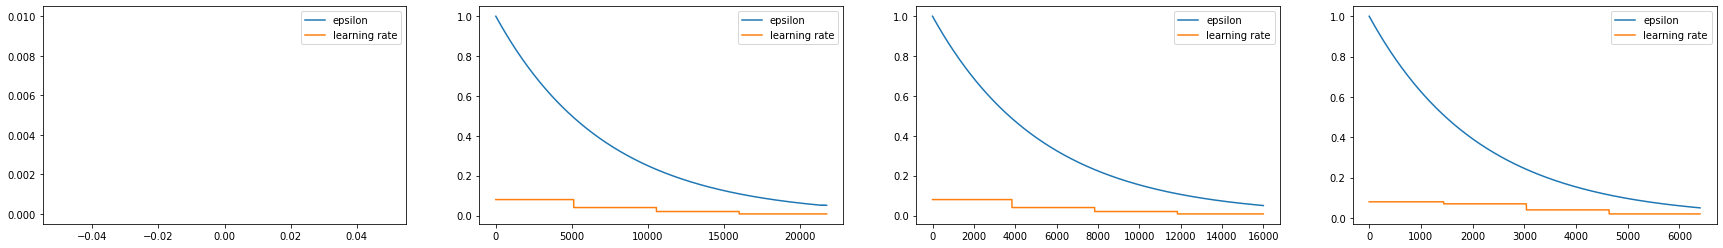

In [12]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

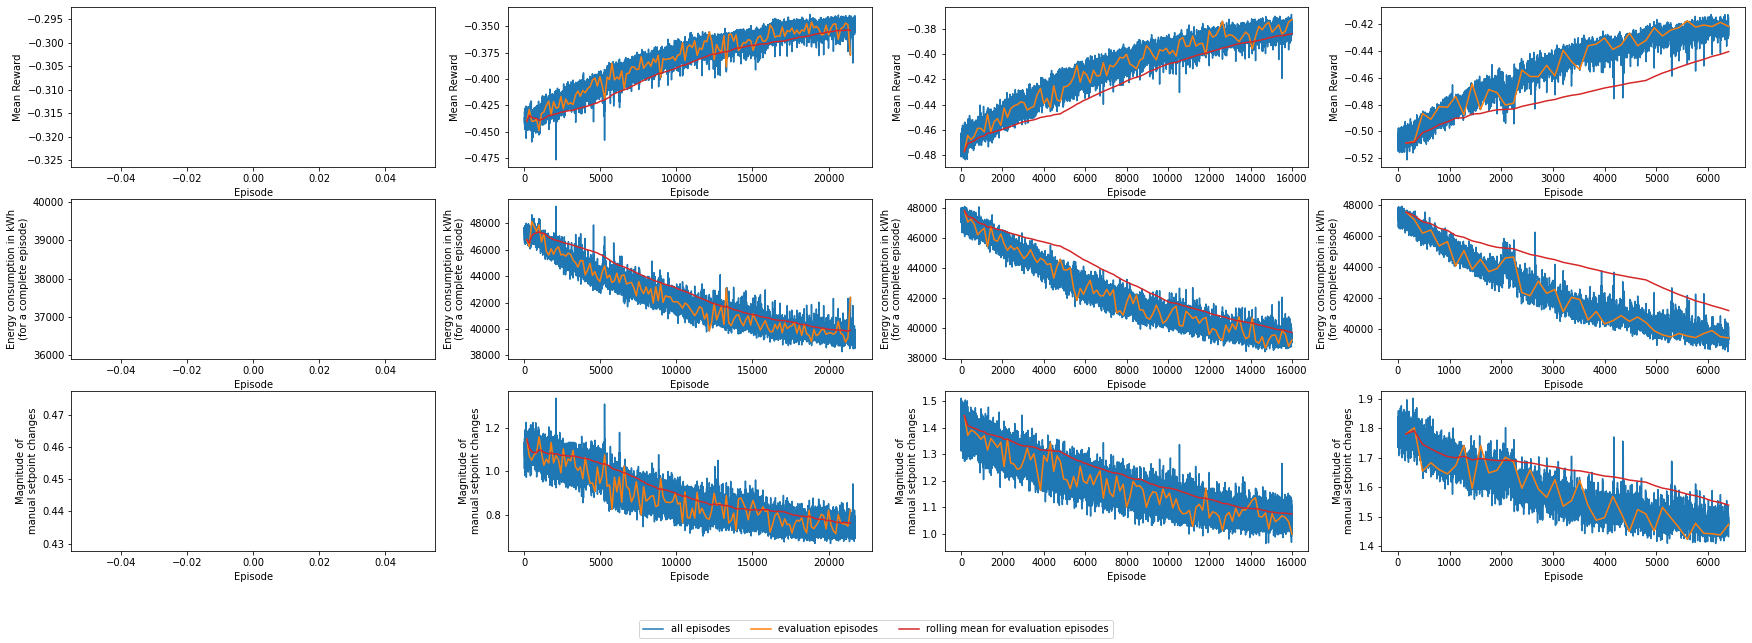

In [13]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

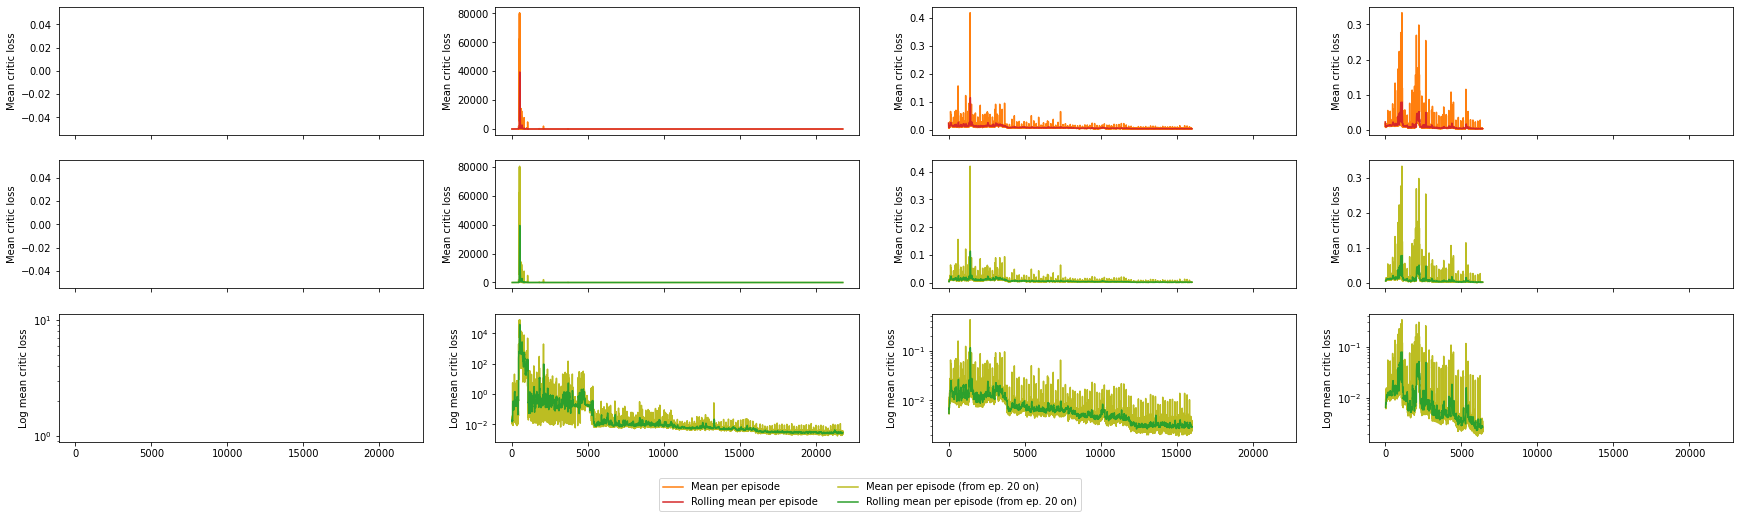

In [14]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

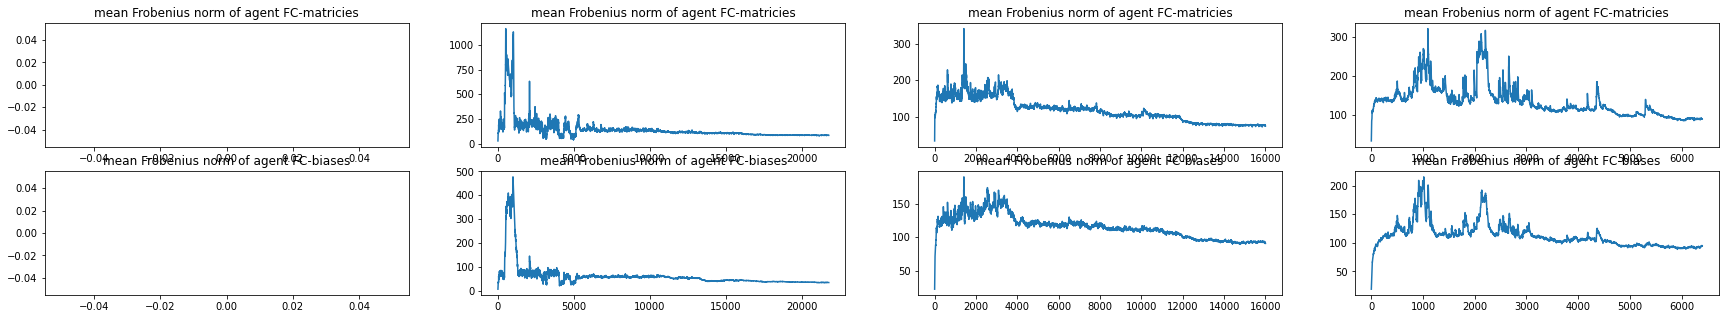

In [15]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [16]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:      0
Last available evaluation episode for dfs1:  21439
Last available evaluation episode for dfs2:  15999
Last available evaluation episode for dfs3:   6399


<h3>Details for one week</h3>

In [17]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [18]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [19]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode     0: Energy consumption:   37992.70 kWh; Numer of setpoint changes: 325.4346284463498
For episode 21439: Energy consumption:   39522.60 kWh; Numer of setpoint changes: 514.1762171971084
For episode 15999: Energy consumption:   39191.30 kWh; Numer of setpoint changes: 718.0267708977854
For episode  6399: Energy consumption:   39438.23 kWh; Numer of setpoint changes: 1059.964487745927

Mean values for episode ...
...     0: Reward: -0.30947 kWh; Setpoint change magnit.:  0.45262; Energy cons.: 52841.03202
... 21439: Reward: -0.34636 kWh; Setpoint change magnit.:  0.71513; Energy cons.: 54968.84799
... 15999: Reward: -0.37241 kWh; Setpoint change magnit.:  0.99865; Energy cons.: 54508.07238
...  6399: Reward: -0.42168 kWh; Setpoint change magnit.:  1.47422; Energy cons.: 54851.50157


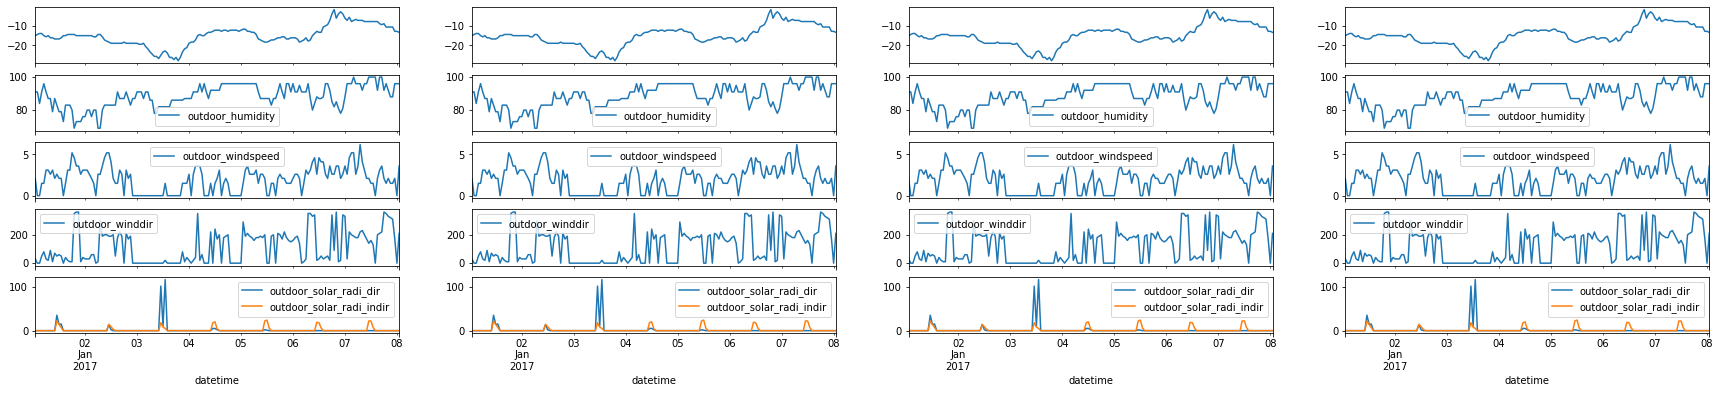

In [20]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

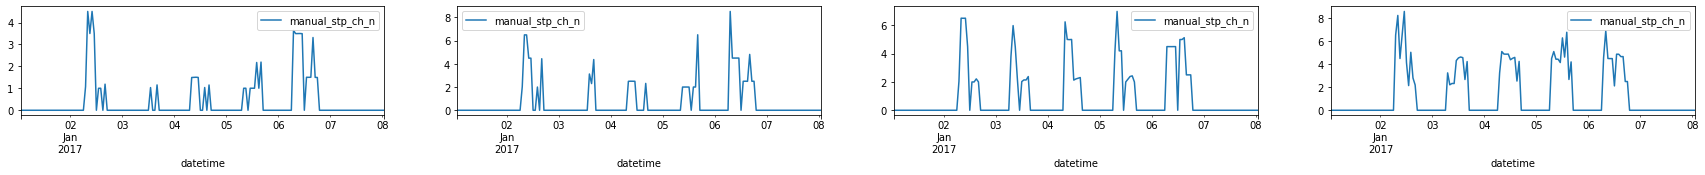

In [21]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

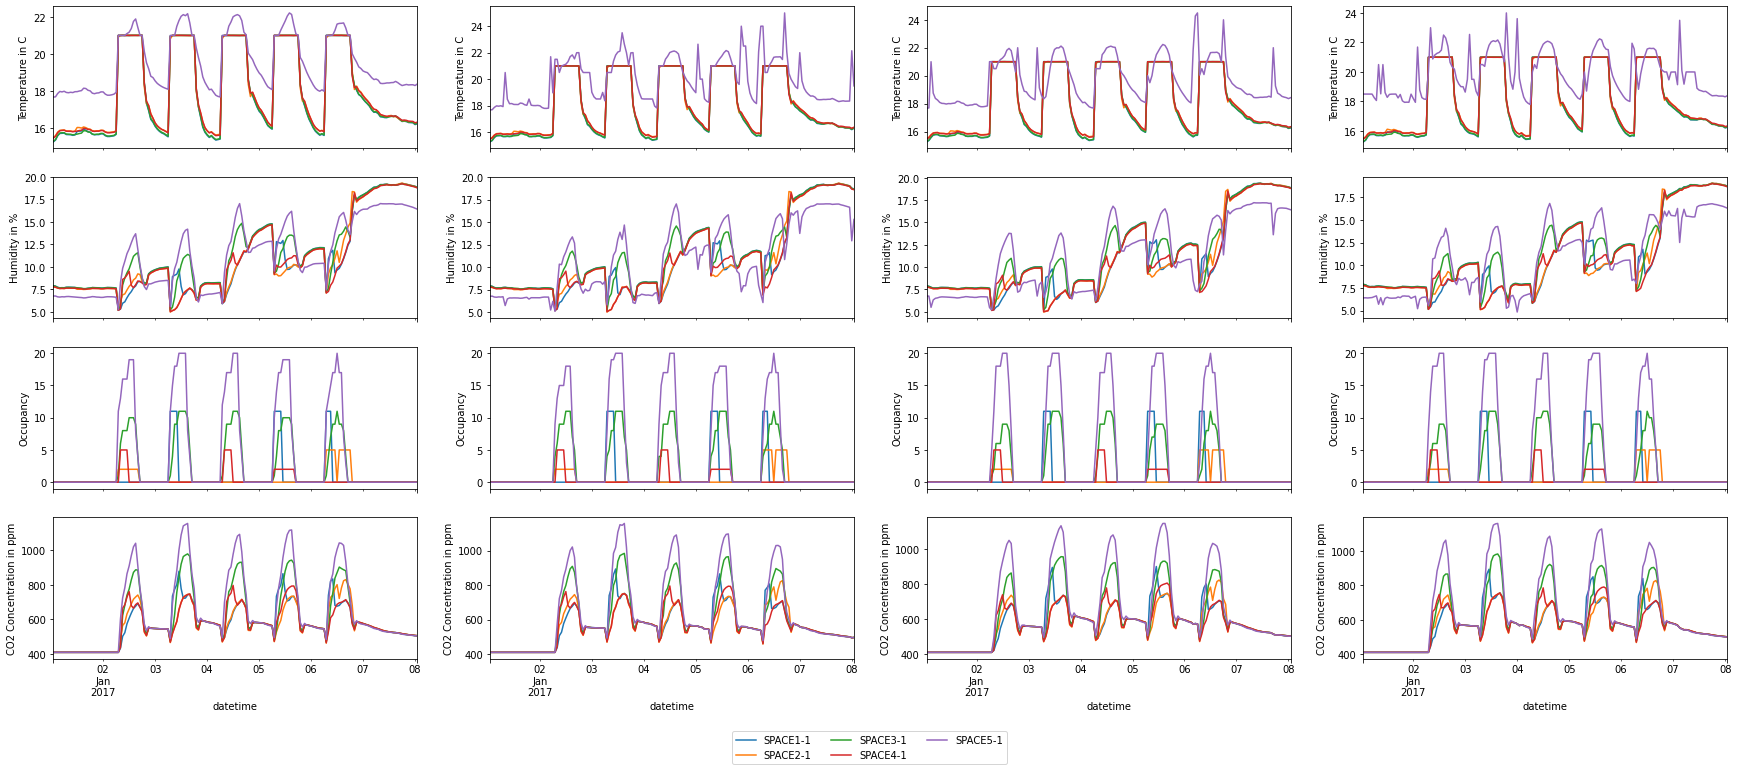

In [22]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [23]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

No agent - controlled device pairing found for index 0
Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

No agent - controlled device pairing found for index 1
Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: {'SPACE1-1': 0, 'SPACE2-1': 1, 'SPACE3-1': 2, 'SPACE4-1': 3, 'SPACE5-1': 4} 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: {'SPACE5-1': 0, 'SPACE4-1': 1, 'SPACE3-1': 2, 'SPACE2-1': 3, 'SPACE1-1': 4} 

Available Rooms     in (sub-)dfs3: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs3: {'SPACE5-1': 0, 'SPACE4-1': 1, 'SPACE3-1': 2, 'SPACE2-1': 3, 'SPACE1-1': 4} 



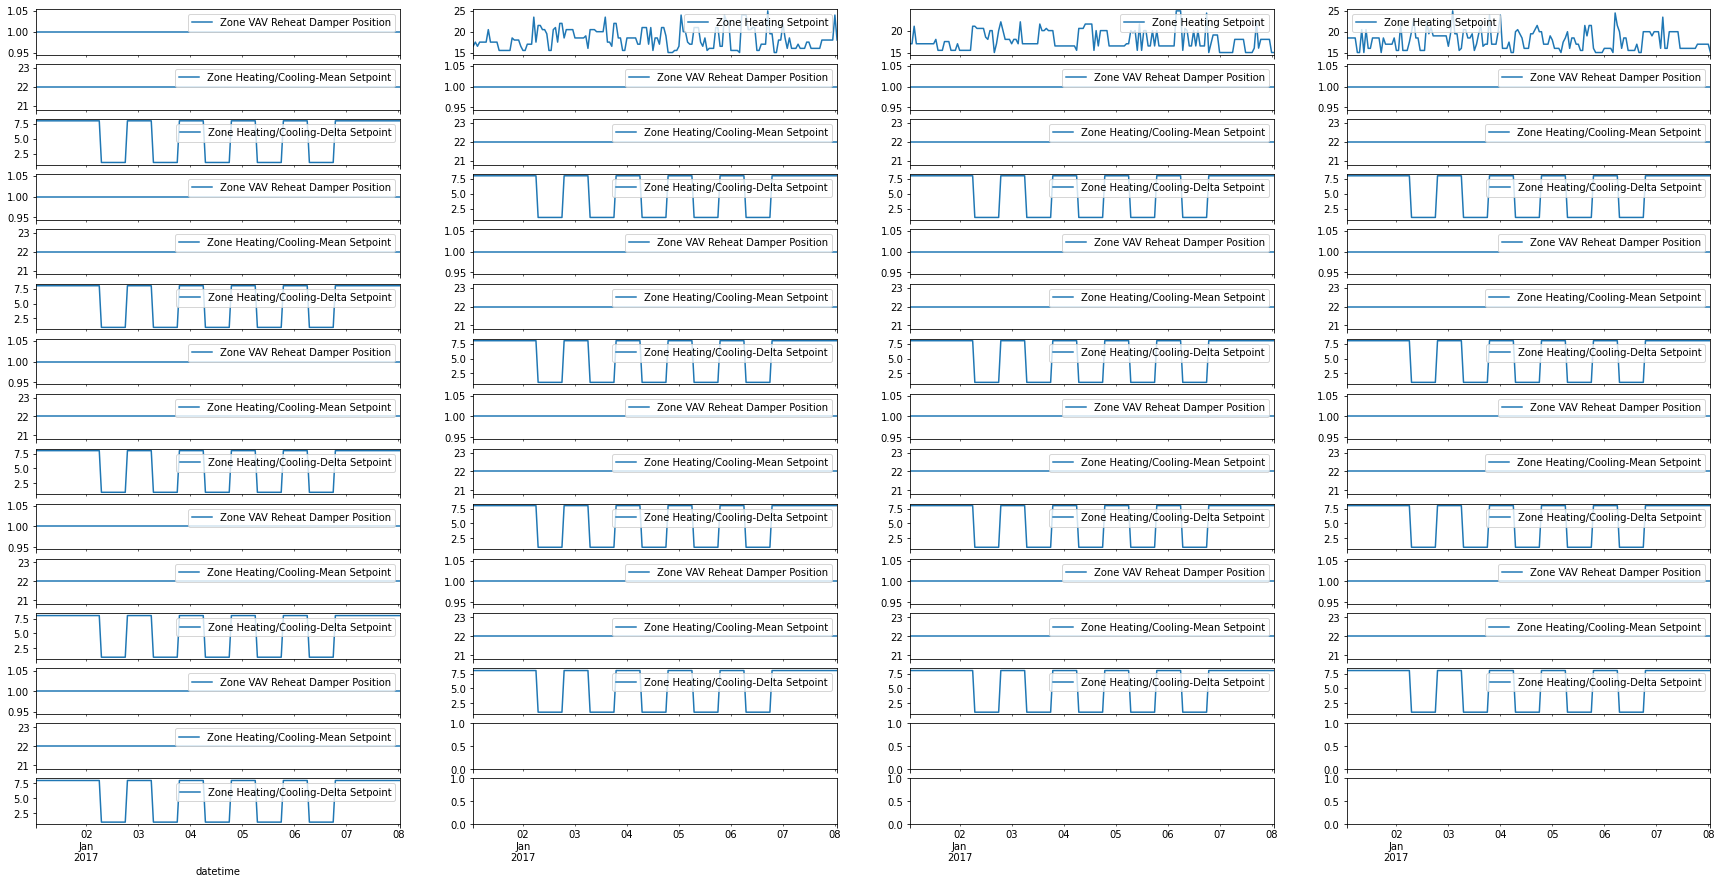

In [24]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

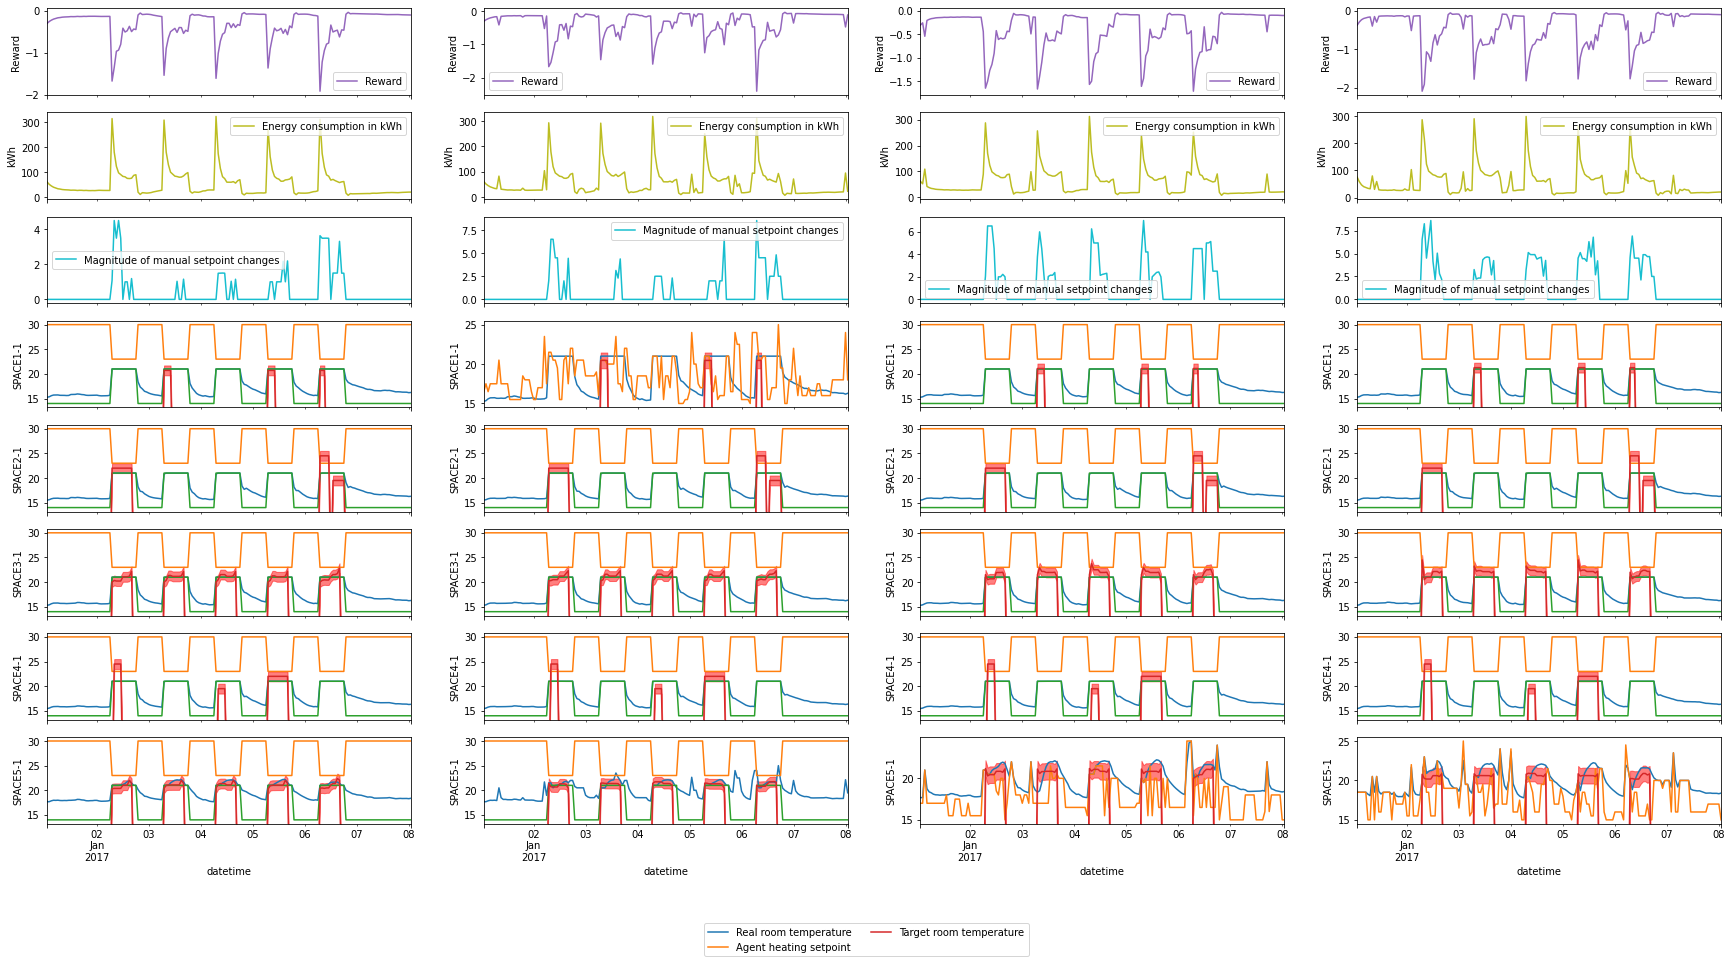

In [25]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [26]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [27]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

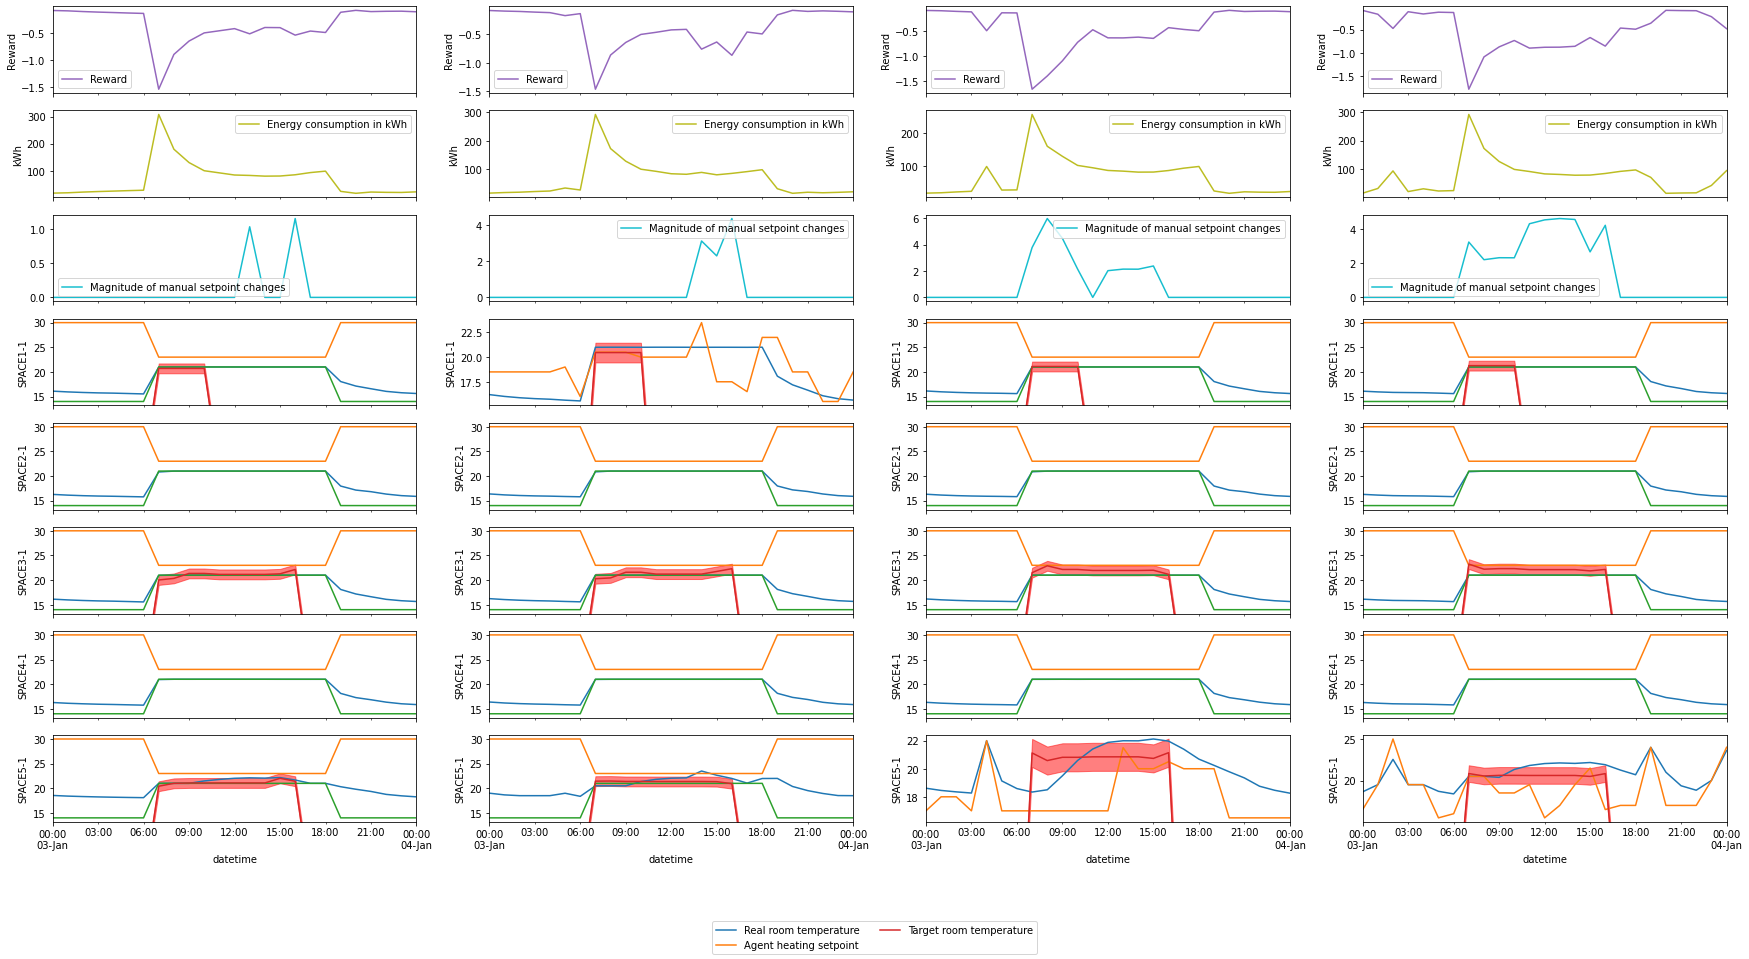

In [28]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [29]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [30]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

For plot number 1, mean energy consumption =  51941.5 Wh, mean reward = -0.3035
For plot number 2, mean energy consumption =  54090.6 Wh, mean reward = -0.3388
For plot number 3, mean energy consumption =  53649.7 Wh, mean reward = -0.3666
For plot number 4, mean energy consumption =  53879.9 Wh, mean reward = -0.4143


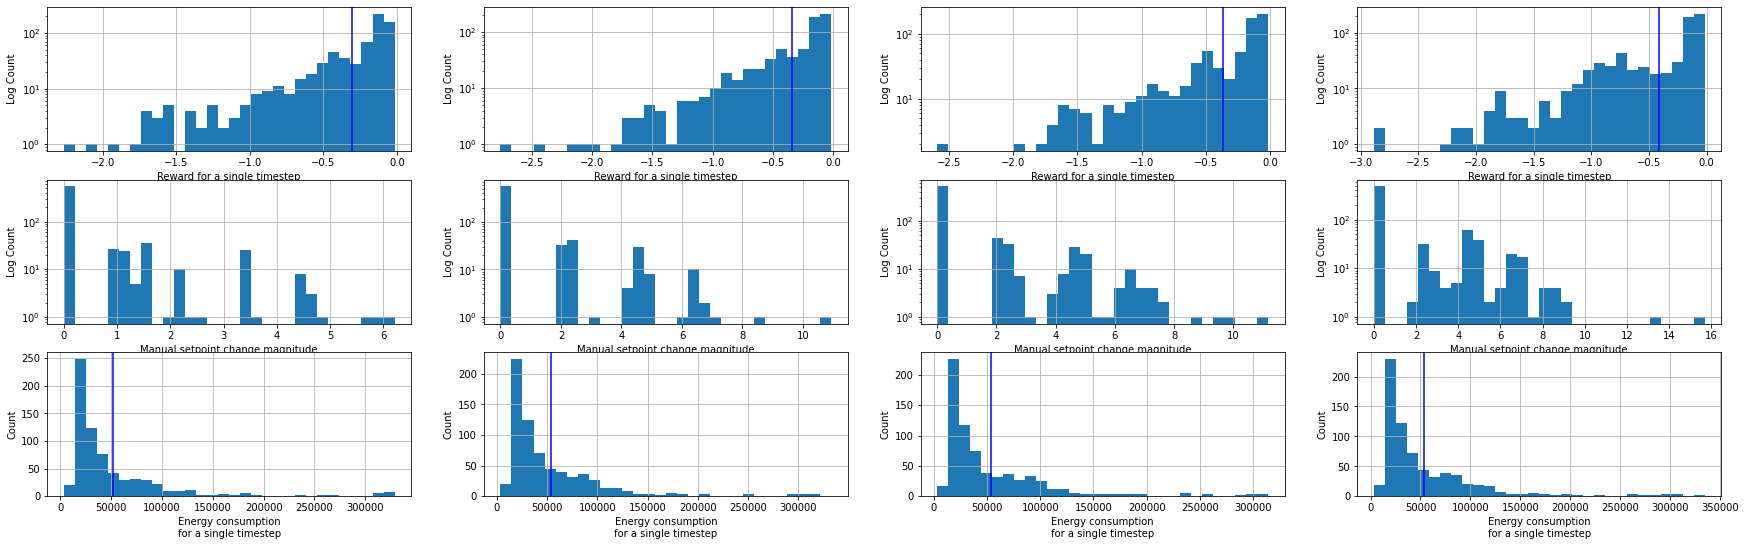

In [31]:
vh.plot_stpch_and_econs_distrib(subdfs, fig_width)

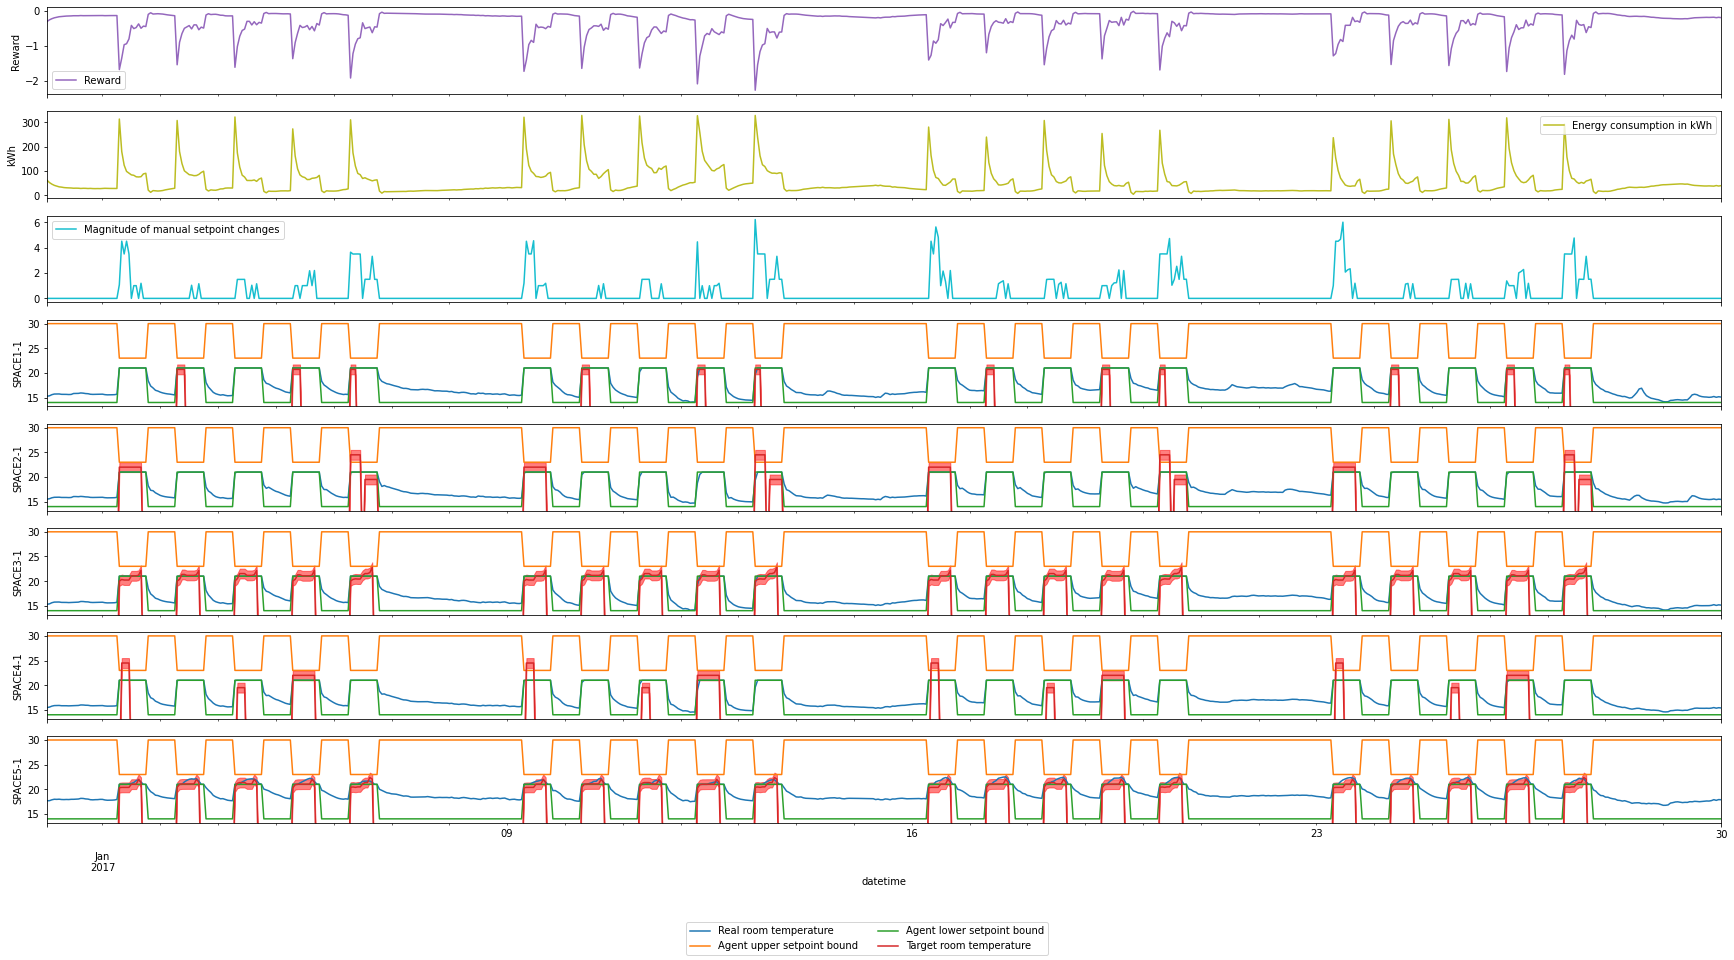

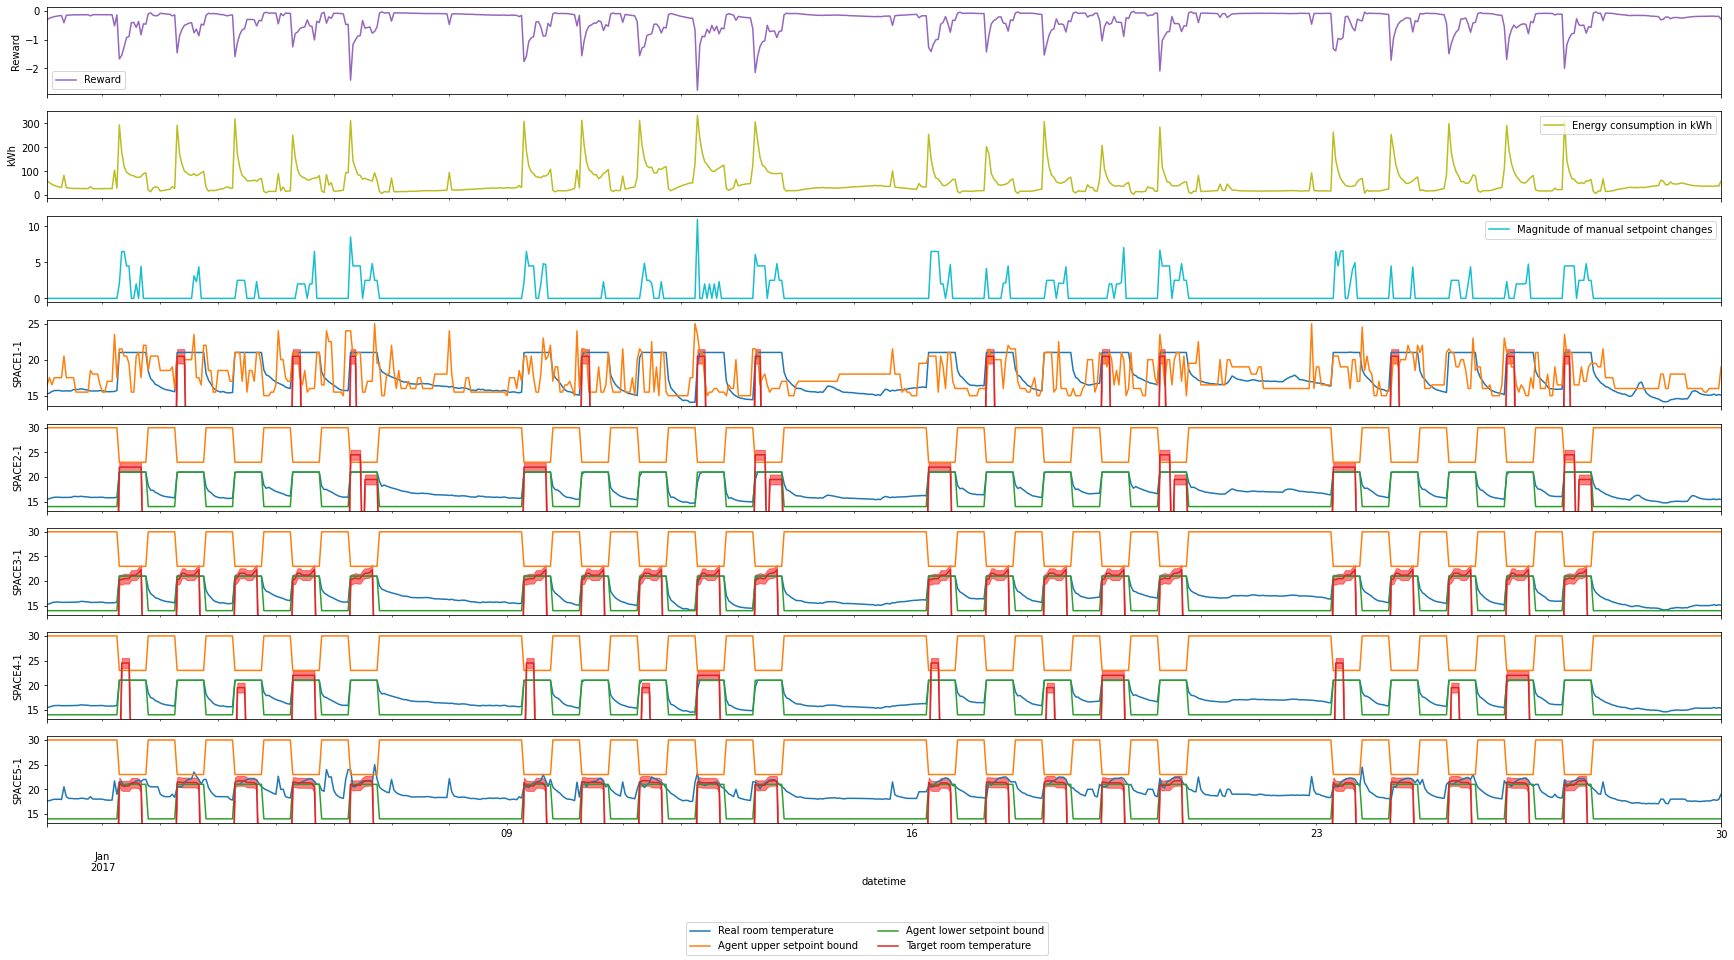

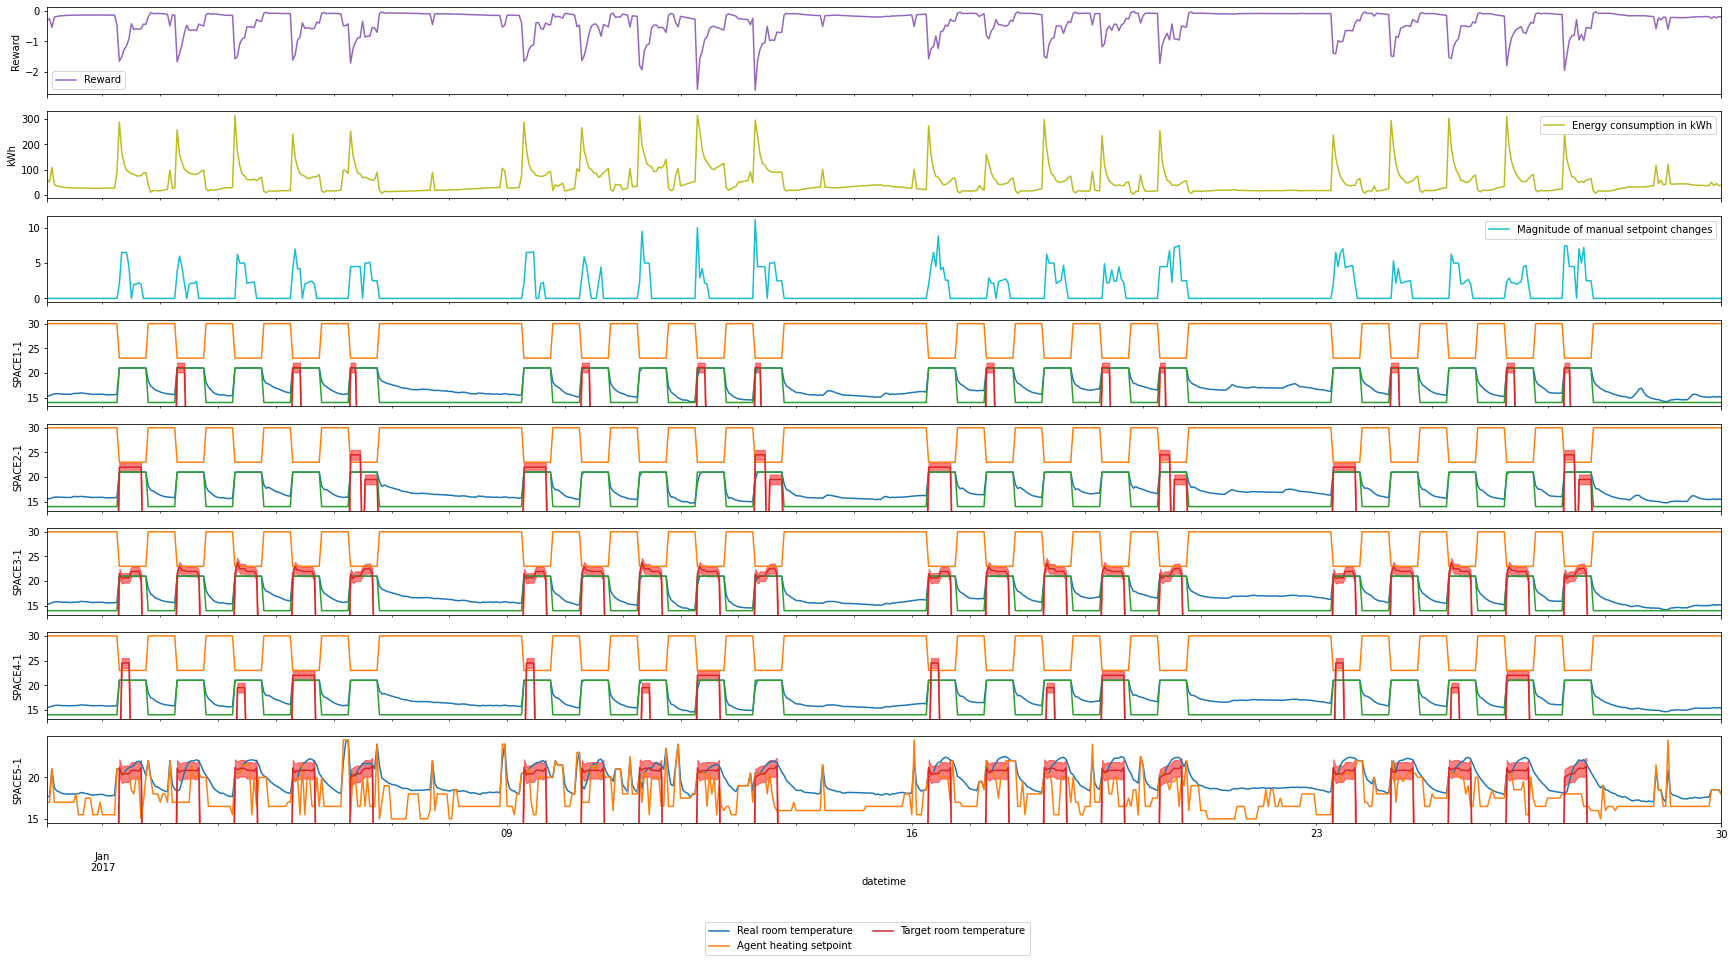

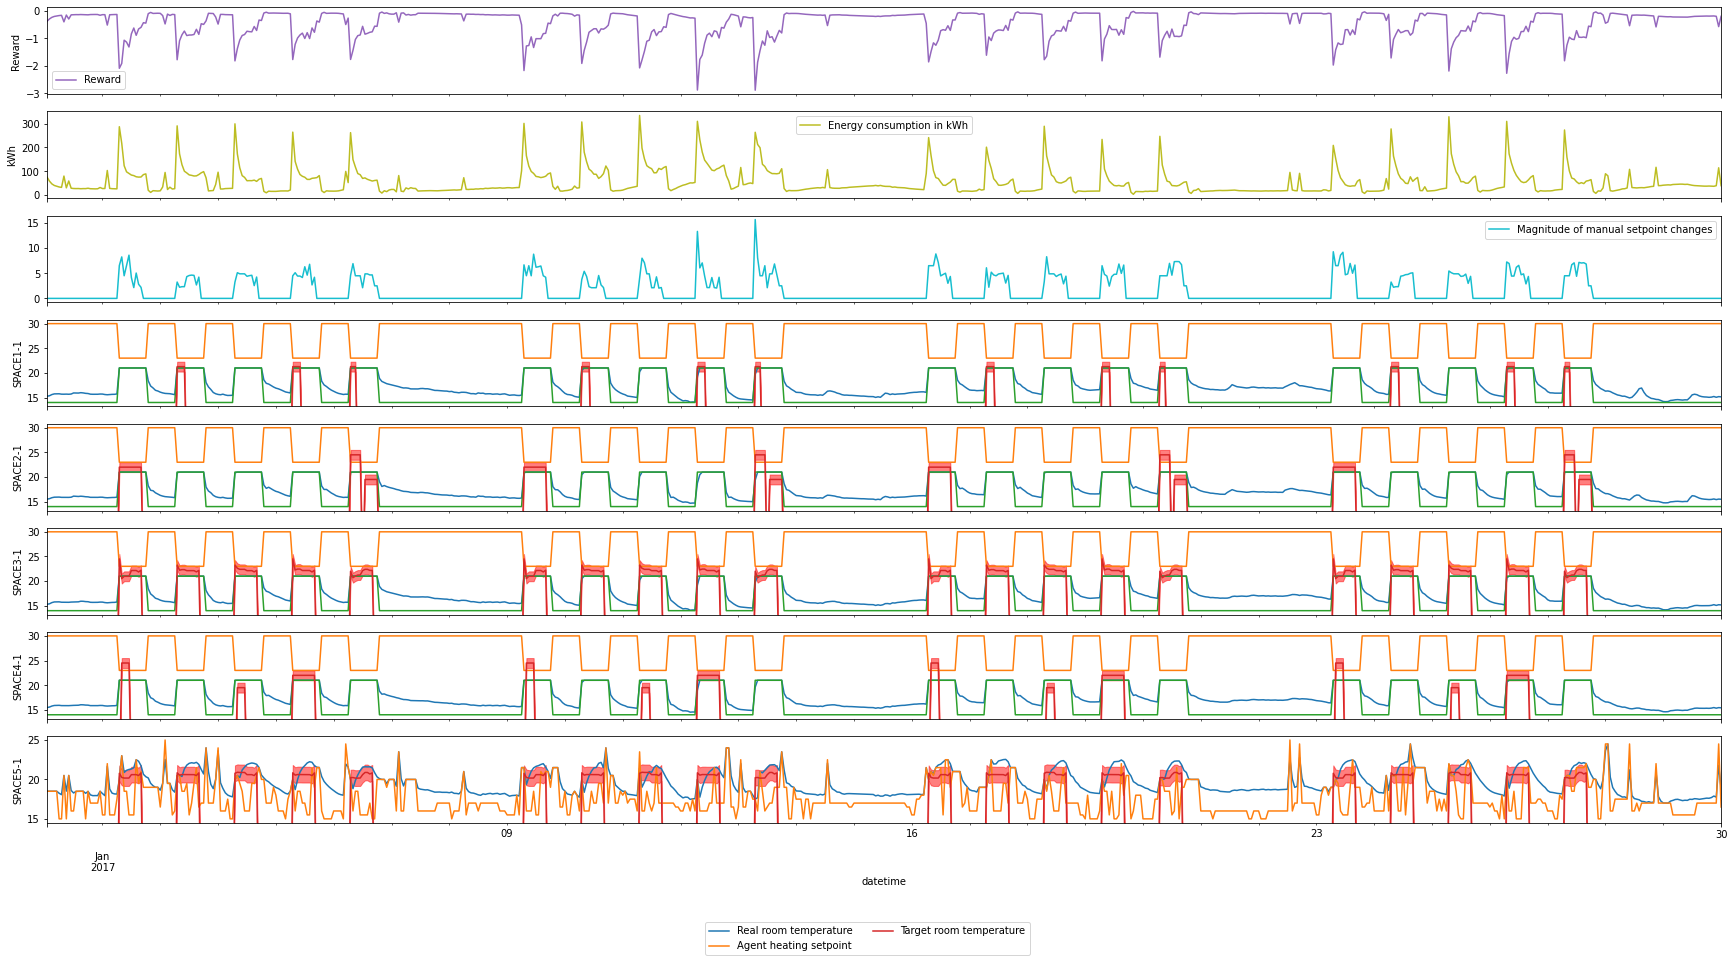

In [32]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

No q-values available for scenario 1: s160, agent 1
No q-values available for scenario 1: s160, agent 2
No q-values available for scenario 1: s160, agent 3
No q-values available for scenario 1: s160, agent 4
No q-values available for scenario 2: s160-layernorm, agent 1
No q-values available for scenario 2: s160-layernorm, agent 2
No q-values available for scenario 2: s160-layernorm, agent 3
No q-values available for scenario 2: s160-layernorm, agent 4
No q-values available for scenario 3: s160-layernorm-fast, agent 1
No q-values available for scenario 3: s160-layernorm-fast, agent 2
No q-values available for scenario 3: s160-layernorm-fast, agent 3
No q-values available for scenario 3: s160-layernorm-fast, agent 4


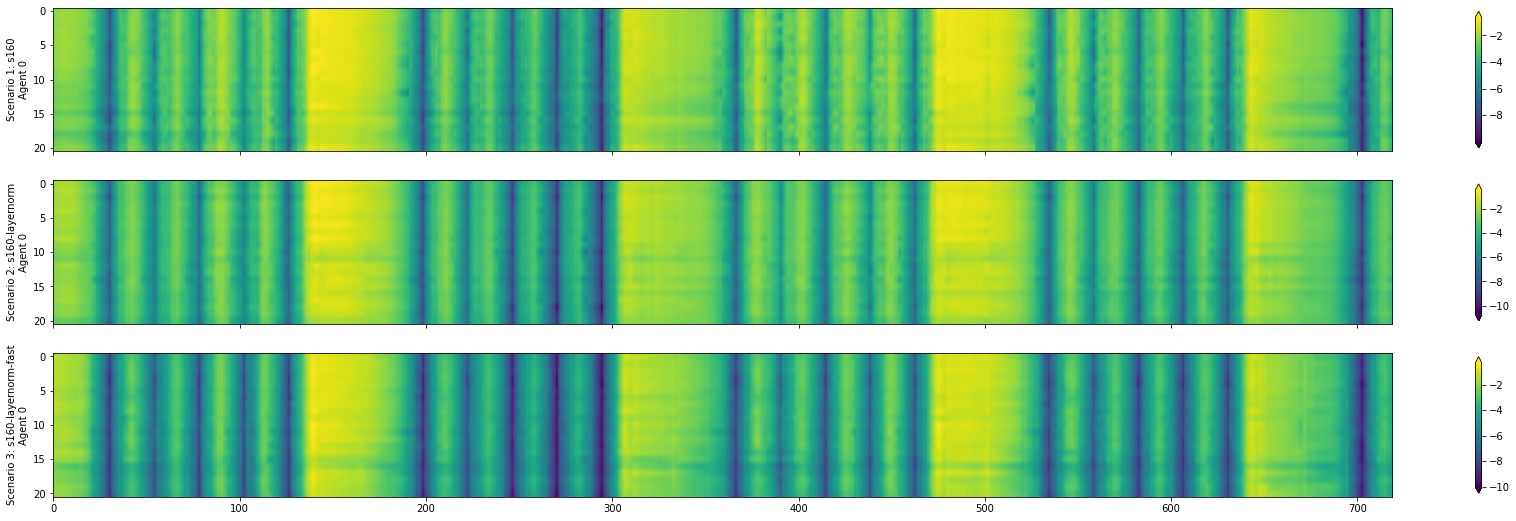

In [33]:
vh.plot_q_values(q_values, fig_width)